# Dataset Preprocessing

In [7]:
import pandas as pd
import numpy as np
import re
import string
import contractions
from functools import reduce
import nltk
from nltk.corpus import stopwords, words, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

# Da inserire nelle dipendenze
from spellchecker import SpellChecker

import numpy as np
import matplotlib.pyplot as plt


In [542]:
nltk.download('words')
nltk.download('wordnet')

## Defining Preprocessing Functions

In this section we define all the preprocessing functions that we used for the preprocessing.

In [543]:
#Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

stop_words.add("mkr")

lemmatizer = WordNetLemmatizer()

ps = PorterStemmer()


In [544]:
#Replace all textual emojis in the string with null character
def remove_textual_emojis(tweet): 
    tweet = re.sub(r"(:[DPp3Oo\(\)])|(:'[\)\(])|(;[\)\(])|(-.-)|(^[._]^)|(x[\(\)])", '', tweet)
    return tweet 


#Replace links and mentions (@) with null character
def remove_links_mentions(tweet): 
    return re.sub(r"((?:\@|https?\:\/\/|www)\S+)|(^RT)", '', tweet)


#Remove all hashtags at the end of the sentence and remove the # symbol from all others
def remove_hashtag(tweet):
    tweet = re.sub(r"(\s+#[\w-]+)+\s*$", '', tweet)
    return re.sub(r"#([\w-]+)", r'\1', tweet)


#Remove multiple spaces (2+) and remove spaces at the beginning and end of the sentence 
def remove_spaces(tweet):
    tweet = re.sub(r"\s{2,}", ' ', tweet)
    tweet = re.sub(r"^\s", '', tweet)
    return re.sub(r"\s$", '', tweet)


#Remove not ASCII characters (it includes not-textual emojis)
def remove_not_ASCII(tweet):
    return tweet.encode("ascii", errors="ignore").decode()


#Expand contractions (e.g.: can't => cannot)
def remove_contractions(tweet):
    return contractions.fix(tweet,slang=True)


#Remove all stopwords
def remove_stopwords(tweet):
    word_tokens = word_tokenize(tweet)
    
    # checks whether they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
            
    return ' '.join(filtered_sentence)


#Remove punctuation symbols
def remove_punctuation(tweet):
    return remove_spaces(tweet.translate(str.maketrans("", "", string.punctuation)))


#Stemming
def stemming(tweet):
    tmp_tweet = word_tokenize(tweet)
    return reduce(lambda x, y: x + ps.stem(y), tmp_tweet, "")


#Remove multiple doubles in each word of the tweet (e.g.: coooll => cooll)
def remove_elongated_words(tweet):
    return re.sub(r'(.)\1+', r'\1\1', tweet)


#Remove & and $ symbols
def remove_special_characters(tweet):
    return re.sub(r'[&$]|amp', '',tweet)


#Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""


In [545]:
# Check words spelling
spell = SpellChecker()

def correct_spelling(tweet):
    words = word_tokenize(tweet)
    misspelled = spell.unknown(words)
    corrected_words = []

    for word in words:
        if word in misspelled:
            correction = spell.correction(word)
            corrected_words.append(correction if correction is not None else word)
        corrected_words.append(word)
    return ' '.join(corrected_words)

# Combine wordnet and the standard list of words in NLTK
english_words = set(words.words())
english_words.update(w for w in wordnet.words())

def remove_non_english(tweet):
    words = word_tokenize(tweet)
    filtered_words = []
    
    for word in words:
        if word in english_words:
            filtered_words.append(word)

    return ' '.join(filtered_words)

In [562]:
def lemmatization_with_pos(sentence):
    wnl = WordNetLemmatizer()
    tagged_words = pos_tag(word_tokenize(sentence))
    lemmatized_words = []
    
    for word, tag in tagged_words:
        wntag = tag[0].lower()  # Get the first character of the tag
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None  # Map POS tags to WordNet POS tags
        if not wntag:
            lemma = word  # If the POS tag is not recognized, use the word as is
        else:
            lemma = wnl.lemmatize(word, pos=wntag)  # Lemmatize the word with its POS tag
        lemmatized_words.append(lemma)
    
    return ' '.join(lemmatized_words)


In [547]:
def index_to_remove(df):
    empty_tweet_indices = df[df['tweet_text'] == ''].index.tolist()
    duplicate_indices = df[df.duplicated()].index.tolist()
    
    indices_to_remove = list(set(empty_tweet_indices + duplicate_indices))
    
    return indices_to_remove

def remove_indices_from_all_datasets(df, indices):
    for dataset in df:
        dataset = dataset.drop(indices, inplace=True)
        dataset = dataset.drop_duplicates()
    return df

def clean_normalized_df(df):
    #Delete empty tweets after the normalization
    df=df.drop(df[(df.tweet_text == r'')].index)  # Rimosse 273 entries
    
    #Check duplicates after the normalization
    df = df.drop_duplicates()

    return df

## Applying Preprocessing

For each model, we need apply different normalization techniques.

In [548]:
def Bayes_normalization(tweet):
    tweet = remove_links_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_hashtag(tweet)
    tweet = remove_special_characters(tweet)
 
    tweet = remove_spaces(tweet)
    tweet = remove_textual_emojis(tweet)
    tweet = remove_not_ASCII(tweet)
    tweet = remove_contractions(tweet)
    tweet = remove_stopwords(tweet)
    tweet = remove_punctuation(tweet)
    tweet = remove_elongated_words(tweet)
    
    tweet = lemmatization_with_pos(tweet)
    
    tweet = remove_short_tweets(tweet, min_words=3)
    
    return tweet

def Bayes_preprocessing(df, ts = 'no'):
    df['tweet_text'] = df['tweet_text'].apply(Bayes_normalization)
    i = []
    if ts == 'no':
        df = clean_normalized_df(df)
    else:
        i = index_to_remove(df)
    return df, i

In [549]:
def Transformers_normalization(tweet):
    tweet = remove_links_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_hashtag(tweet)
    tweet = remove_special_characters(tweet)
 
    tweet = remove_spaces(tweet)
    tweet = remove_textual_emojis(tweet)
    tweet = remove_not_ASCII(tweet)
    return tweet

def Transformers_preprocessing(df, ts = 'no'):
    df['tweet_text'] = df['tweet_text'].apply(Transformers_normalization)
    i = []
    if ts == 'no':
        df = clean_normalized_df(df)
    else:
        i = index_to_remove(df)
    return df, i

In [550]:
def LSTM_normalization(tweet):
    tweet = remove_links_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_hashtag(tweet)
    tweet = remove_special_characters(tweet)
 
    tweet = remove_spaces(tweet)
    tweet = remove_textual_emojis(tweet)
    tweet = remove_not_ASCII(tweet)
    tweet = remove_contractions(tweet)
    tweet = remove_stopwords(tweet)
    tweet = remove_punctuation(tweet)
    tweet = remove_elongated_words(tweet)
    
    tweet = correct_spelling(tweet)
    tweet = remove_non_english(tweet)
    tweet = remove_short_tweets(tweet, min_words=3)

    return tweet

def LSTM_normalization2(tweet):
    tweet = remove_links_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_hashtag(tweet)
    tweet = remove_special_characters(tweet)
 
    tweet = remove_spaces(tweet)
    tweet = remove_textual_emojis(tweet)
    tweet = remove_not_ASCII(tweet)
    tweet = remove_contractions(tweet)
    tweet = remove_stopwords(tweet)
    tweet = remove_punctuation(tweet)
    tweet = remove_elongated_words(tweet)

    tweet = remove_short_tweets(tweet, min_words=3)

    return tweet

def LSTM_preprocessing(df, preprocessing = 'yes', ts = 'no'):
    i = [] 
    if preprocessing == 'yes':
        df['tweet_text'] = df['tweet_text'].apply(LSTM_normalization)
        if ts == 'no':
            df = clean_normalized_df(df)
        else:
            i = index_to_remove(df)
    else:
        df['tweet_text'] = df['tweet_text'].apply(LSTM_normalization2)
        if ts == 'no':
            df = clean_normalized_df(df)
        else:
            i = index_to_remove(df)
    return df, i

We noticed that different kinds of preprocessing yields to different results in the resulting dataset. To test the performances of different models, we want to ensure that all are evaluated on the exact same test set.

In [551]:
df = pd.read_csv('../../data/test_tweets.csv')
ts_bayes, bayes_indices = Bayes_preprocessing(df, 'yes')

df = pd.read_csv('../../data/test_tweets.csv')
ts_transformers, trans_indices = Transformers_preprocessing(df, 'yes')

df = pd.read_csv('../../data/test_tweets.csv')
ts_LSTM_pro, lstm_indices_pro = LSTM_preprocessing(df, 'yes', 'yes')

df = pd.read_csv('../../data/test_tweets.csv')
ts_LSTM_no, lstm_indices_no = LSTM_preprocessing(df, 'no', 'yes')

In [552]:
# Convert indexes in textx
bayes_indices = set(bayes_indices)
trans_indices = set(trans_indices)
lstm_indices_pro = set(lstm_indices_pro)
lstm_indices_no = set(lstm_indices_no)

all_indices = trans_indices.union(bayes_indices).union(lstm_indices_no).union(lstm_indices_pro)

# Remove indexes from original database
df_bayes = ts_bayes.drop(all_indices, axis=0)
df_transformers = ts_transformers.drop(all_indices, axis=0)
df_LSTM_pro = ts_LSTM_pro.drop(all_indices, axis=0)
df_LSTM_no = ts_LSTM_no.drop(all_indices, axis=0)

df_bayes.to_csv("TS_NB.csv", index=False)
df_transformers.to_csv("TS_T.csv", index=False)
df_LSTM_pro.to_csv("TS_LSTM_P.csv", index=False)
df_LSTM_no.to_csv("TS_LSTM_NP.csv", index=False)

In [553]:
class_countsts = df_LSTM_pro['cyberbullying_type'].value_counts()
print("Test set distirbution for LSTM_pro:")
print(class_countsts)
print()

class_countsts = df_LSTM_no['cyberbullying_type'].value_counts()
print("Test set distirbution for LSTM_nopro:")
print(class_countsts)
print()



Test set distirbution for LSTM_pro:
cyberbullying_type
religion             1614
age                  1568
ethnicity            1502
gender               1497
not_cyberbullying    1338
Name: count, dtype: int64

Test set distirbution for LSTM_nopro:
cyberbullying_type
religion             1614
age                  1568
ethnicity            1502
gender               1497
not_cyberbullying    1338
Name: count, dtype: int64



In [554]:
class_countsts = df_bayes['cyberbullying_type'].value_counts()
print("Test set distirbution for Naive Bayes:")
print(class_countsts)
print()

class_countsts = df_transformers['cyberbullying_type'].value_counts()
print("Test set distirbution for BERT:")
print(class_countsts)
print()

Test set distirbution for Naive Bayes:
cyberbullying_type
religion             1614
age                  1568
ethnicity            1502
gender               1497
not_cyberbullying    1338
Name: count, dtype: int64

Test set distirbution for BERT:
cyberbullying_type
religion             1614
age                  1568
ethnicity            1502
gender               1497
not_cyberbullying    1338
Name: count, dtype: int64



Let us create test and validation sets for different models.

In [555]:
pool = {"../../data/train_tweets.csv", "../../data/eval_tweets.csv"}

In [556]:
for file in pool:
    df = pd.read_csv(file)
    df, _ = Bayes_preprocessing(df, 'no')
    file = file.split(".csv")[0]
    df.to_csv(file+"_Naive_Bayes_new.csv", index=False)

In [557]:
for file in pool:
    df = pd.read_csv(file)
    df, _= LSTM_preprocessing(df, 'yes', 'no')
    file = file.split(".csv")[0]
    df.to_csv(file+"_LSTM_pre_new.csv", index=False)

In [558]:
for file in pool:
    df = pd.read_csv(file)
    df, _ = LSTM_preprocessing(df, 'no', 'no')
    file = file.split(".csv")[0]
    df.to_csv(file+"_LSTM_no_new.csv", index=False)

In [559]:
for file in pool:
    df = pd.read_csv(file)
    df, _= Transformers_preprocessing(df, 'no')
    file = file.split(".csv")[0]
    df.to_csv(file+"_Transformers_new.csv", index=False)

## Verifying Preprocessing Results

In [ ]:
def create_pie_chart(data, labels, colors, explode=None, title=None):
    # Uniform explode to slightly separate the slices
    if explode is None:
        explode = (0.05,) * len(data)

    # Wedge properties
    wp = {'linewidth': 1, 'edgecolor': "silver"}

    # Autopct function to format the label texts
    def func(pct, allvalues):
        absolute = int(pct / 100. * np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    # Creating the pie chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(
        data,
        autopct=lambda pct: func(pct, data),
        explode=explode,
        labels=labels,
        shadow=True,
        colors=colors,
        startangle=140,
        wedgeprops=wp,
        textprops={'fontsize': 8}
    )

    # Legend
    ax.legend(wedges, labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Set the automatic text properties and title
    plt.setp(autotexts, size=8, weight="bold", color="black")
    if title:
        ax.set_title(title)

    # Show the plot
    plt.show()


colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F"]

### Training set

Length of the training set LSTM - no preprocessing: 24183


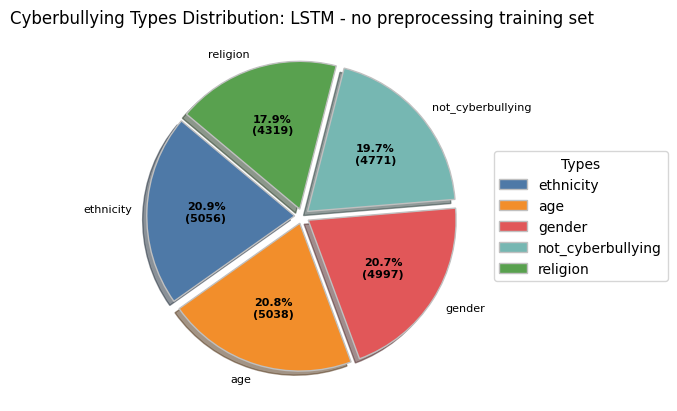

In [22]:
df = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/train_tweets_LSTM_no_new.csv')
print(f"Length of the training set LSTM - no preprocessing: {len(df)}")
cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values
create_pie_chart(cyt_values, cyberbullying_types, colors, title="Cyberbullying Types Distribution: LSTM - no preprocessing training set")

Length of the training set LSTM - preprocessing: 23789


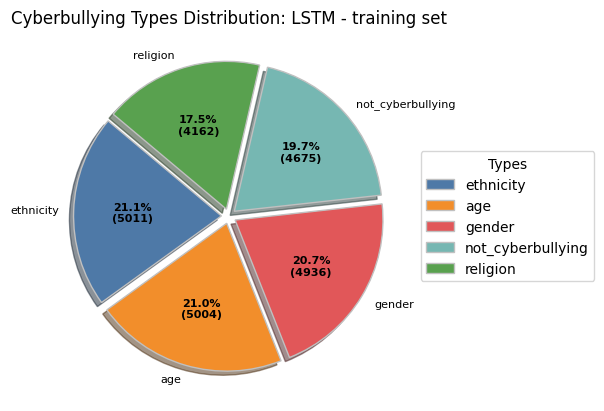

In [32]:
df = pd.read_csv('../../data/New dataset/LSTM/preprocessing/train_tweets_LSTM_pre_new.csv')
print(f"Length of the training set LSTM - preprocessing: {len(df)}")
cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values
create_pie_chart(cyt_values, cyberbullying_types, colors, title="Cyberbullying Types Distribution: LSTM - training set")

Length of the training set BERT: 25155


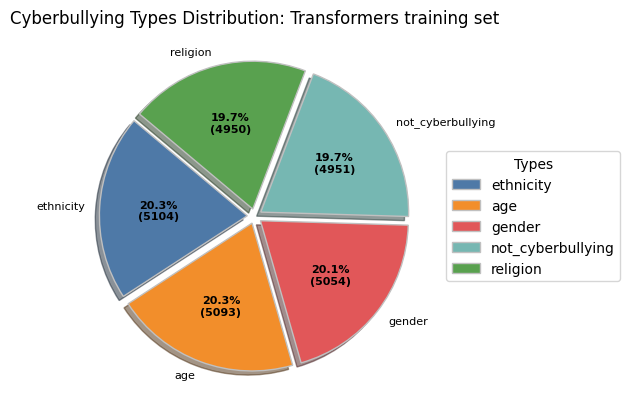

In [25]:
df = pd.read_csv('../../data/New dataset/BERT/train_tweets_Transformers_new.csv')
print(f"Length of the training set BERT: {len(df)}")
cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values
create_pie_chart(cyt_values, cyberbullying_types, colors, title="Cyberbullying Types Distribution: Transformers training set")

Length of the training set Naive Bayes: 24165


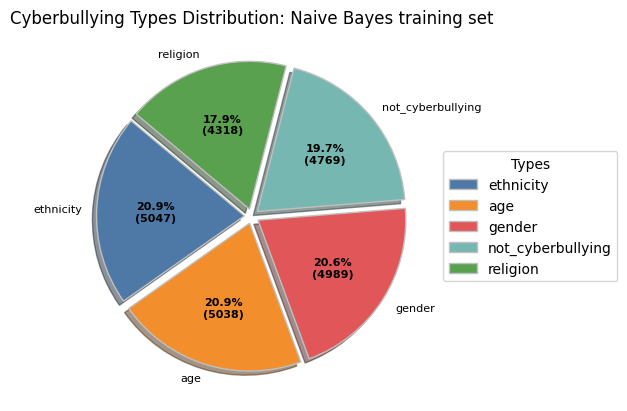

In [27]:
df = pd.read_csv('../../data/New dataset/Naive Bayes/train_tweets_Naive_Bayes_new.csv')
print(f"Length of the training set Naive Bayes: {len(df)}")
cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values
create_pie_chart(cyt_values, cyberbullying_types, colors, title="Cyberbullying Types Distribution: Naive Bayes training set")

### Validation Set

Then we checked the validation set.

Length of the validation set LSTM - no prepocessing: 6106


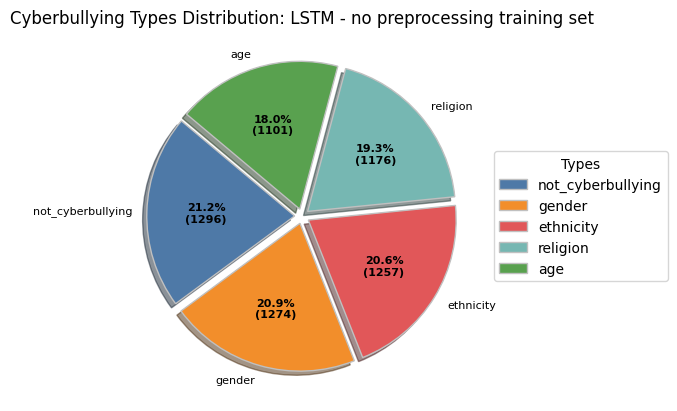

In [28]:
df = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/eval_tweets_LSTM_no_new.csv')
print(f"Length of the validation set LSTM - no prepocessing: {len(df)}")
cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values
create_pie_chart(cyt_values, cyberbullying_types, colors, title="Cyberbullying Types Distribution: LSTM - no preprocessing training set")

Length of the validation set LSTM - prepocessing: 6028


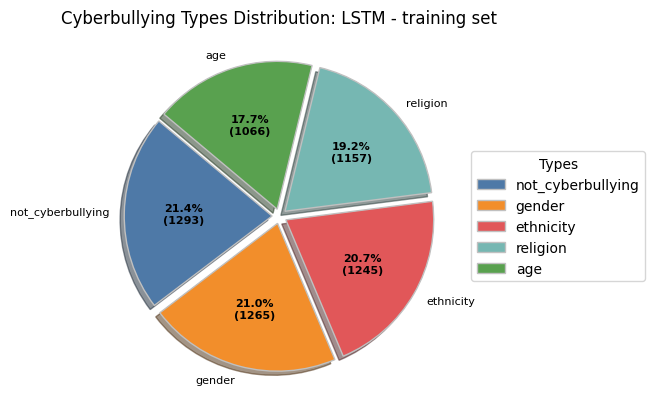

In [29]:
df = pd.read_csv('../../data/New dataset/LSTM/preprocessing/eval_tweets_LSTM_pre_new.csv')
print(f"Length of the validation set LSTM - prepocessing: {len(df)}")
cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values
create_pie_chart(cyt_values, cyberbullying_types, colors, title="Cyberbullying Types Distribution: LSTM - training set")

Length of the validation set BERT: 6325


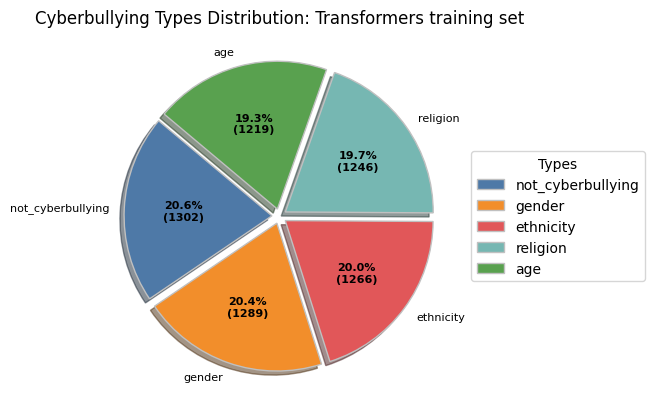

In [30]:
df = pd.read_csv('../../data/New dataset/BERT/eval_tweets_Transformers_new.csv')
print(f"Length of the validation set BERT: {len(df)}")
cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values
create_pie_chart(cyt_values, cyberbullying_types, colors, title="Cyberbullying Types Distribution: Transformers training set")

Length of the validation set Naive Bayes: 6101


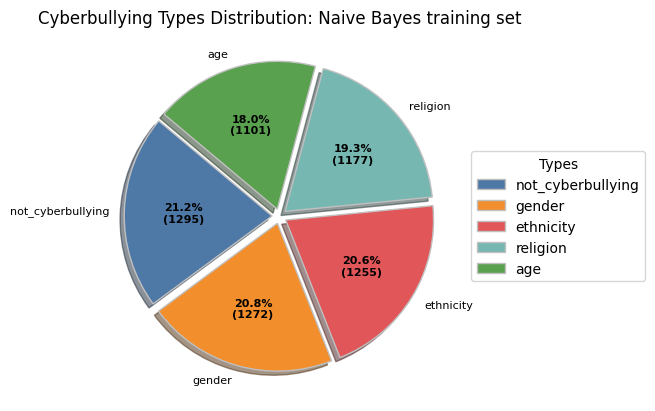

In [31]:
df = pd.read_csv('../../data/New dataset/Naive Bayes/eval_tweets_Naive_Bayes_new.csv')
print(f"Length of the validation set Naive Bayes: {len(df)}")
cyberbullying_types = df['cyberbullying_type'].unique()
cyt_values = df['cyberbullying_type'].value_counts().values
create_pie_chart(cyt_values, cyberbullying_types, colors, title="Cyberbullying Types Distribution: Naive Bayes training set")